# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [11]:
# Import the different libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as st

In [12]:
# Import dataset into dataframe
df = pd.read_csv('data/human_body_temperature.csv')
sns.set()

### 1. Is the distribution of body temperatures normal?

In [13]:
# Checking data for any nulls
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [14]:
df.head(10)

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0
5,99.2,M,83.0
6,98.0,M,71.0
7,98.8,M,78.0
8,98.4,F,84.0
9,98.6,F,86.0


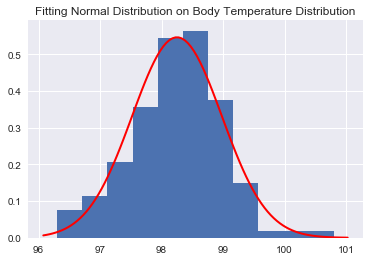

In [15]:
# GRAPHICAL REPRESENTATION OF THE DATA

# Determining bin size
bin_num = int(np.sqrt(len(df.temperature)))

# Extracting the mean and standard deviation from the temperature distribution:
mu, std = st.norm.fit(df.temperature)

# Plot the histogram.
plt.hist(df.temperature, bins=bin_num, density=True)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = st.norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2)
title = "Fitting Normal Distribution on Body Temperature Distribution"
plt.title(title)

plt.show()

**The data is looking to be approximately normally distributed. To further confirm this, we use the Q-Q plot function.**

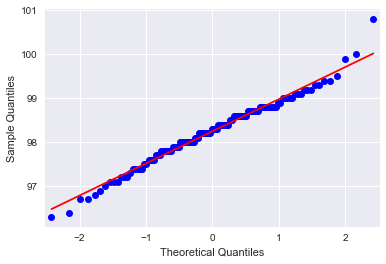

In [16]:
# Using the Q-Qplot to test for normality

qqplot(df.temperature, line = 's')
plt.show()

We see that the data points from the temperature distribution closely fit the normal distribution line.
hence we can conclude that the temperature distribution is normal

### 2. Is the sample size large? Are the observations independent?

From the Central Limit theorem the sample size **n** is considered large enough if **n >= 30**

In [17]:
# determine sample size

sample_size = len(df.temperature)

if sample_size >= 30:
    print('The sample size is large enough as the sample size,',sample_size,'is >= 30')
else:
    print('The sample size is not large enough')

The sample size is large enough as the sample size, 130 is >= 30


**Are the observations independent?**

The Observations can be assumed independent based on the following considerations:

1.) The body temperature of one person does not depend on that of another.

2.) 130 samples is < 10% of the human population.

### 3. Is the true population mean really 98.6 degrees F?

 H0 : The true population mean is mu = 98.6ºF
 
 Ha : The true population mean is mu ≠ 98.6ºF

In [18]:
np.random.seed(42)
alpha = 0.05

def bootstrap_replicate_1d(data, func):
    """Creating a bootstrap replicate (a statistic computed from a bootstrap sample)"""
    #creating a bootstrap sample (a resampled array of the data)
    bs_sample = np.random.choice(data,size=len(data))
    bs_replicate = func(bs_sample)
    
    return bs_replicate


def draw_bs_rep(data, func, size=1):
    """Draw bootstrap replicates"""
    #initialize array of replicates
    btstrp_reps = np.empty(size)
    
    #Generate replicates
    for i in range(size):
        btstrp_reps[i] = bootstrap_replicate_1d(data,func)
        
    return btstrp_reps

#make an array of translated body temperatures assuming H0 is True i.e mu = 98.6

translt_bt = df.temperature - np.mean(df.temperature) + 98.6

# Draw bootstrap 10000 mean replicates of the data
trans_bs_replicates = draw_bs_rep(translt_bt, np.mean, 10000)

p = np.sum(trans_bs_replicates <= np.mean(df.temperature))/len(trans_bs_replicates)

if p < alpha :
    print(f'The p-value is: {p}. We reject the null hypothesis "H0 : The true population mean mu = 98.6ºF" and suggest the alternate "Ha : The true population mean mu ≠ 98.6ºF"')
else:
    print(f'The p-value is: {p}.We fail to reject the null hypothesis. There is a likelihood that the True population body temperature is 98.6ºF')

The p-value is: 0.0. We reject the null hypothesis "H0 : The true population mean mu = 98.6ºF" and suggest the alternate "Ha : The true population mean mu ≠ 98.6ºF"


**Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?**

I would use a one sample test because I am not comparing two sets of data but one set of data to a single number

**In this situation, is it appropriate to use the  t
  or  z
  statistic?**

It is appropriate to use both but more so the t-statistic because we do not know the population standard deviation. we are comparing the means of observations from which we could calculate the sample standard deviation and approximate it to be equal to the population standard deviation.

At the same time we can use the z-statistic because the sample size n > 30.



In [19]:
# Calculating t-statistic.

n = len(df.temperature)  # sample size
mu_zero = 98.6  # null-hypothesis of body temperature means
mu_smpl = np.mean(df.temperature)
std_smpl = np.std(df.temperature)

t_stat = (mu_smpl - mu_zero)/(std_smpl/np.sqrt(n))


dgofrdm = n - 1
pval = st.t.cdf(t_stat, dgofrdm)

print("t = " + str(t_stat))
print("p = " + str(2*pval)) #  multiply by 2 to get a two tailed test since the alternate hypothesis suggests mean could be higher or lower

#Checking using Scipy built-in ttest function.

t_stat_val, p_val = st.ttest_1samp(df.temperature,mu_zero)

print ('Using scipy we have t-statistic =',t_stat_val, 'and p-value =',p_val)

t = -5.475925202078116
p = 2.1887464624095175e-07
Using scipy we have t-statistic = -5.4548232923645195 and p-value = 2.4106320415561276e-07


** Now try using the other test. How is the result be different? Why?**

In [20]:
# Calculating p-value using Z-statistic.
z_stat = t_stat

p_valz = st.norm.cdf(z_stat)

print("z =" ,z_stat)
print("p =" ,2*p_valz)


z = -5.475925202078116
p = 4.3523151658821886e-08


p << 0.05 hence we reject the null hypothesis and suggest the alternate as earlier shown using the bootstrap hypothesis.

The p-value of the t-test is greater than that of the z-test but both < alpha (significance level)

### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

In [39]:
# Drawing 10 samples from population using bootstrapping.

bs_bodytemp = np.random.choice(df.temperature,size=10)

nt = len(bs_bodytemp)
mu_nt = np.mean(bs_bodytemp)
std_nt = np.std(bs_bodytemp)

# T-statistic

t_stat_10 = (mu_nt - mu_zero)/(std_nt/np.sqrt(nt))

dgof = nt - 1
pval_10t = st.t.cdf(t_stat_10, dgof)

# z-statistic

z_stat_10 = t_stat_10

p_valz_10 = st.norm.cdf(z_stat_10)

print("t-statistic from 10 samples = " ,t_stat_10)
print("z-statistic from 10 samples =" ,z_stat_10)
print("p-value from using t-statistic of 10 samples ", 2*pval_10t)
print("p-value from using z-statistic of 10 samples =" ,2*p_valz_10)


t-statistic from 10 samples =  -2.7122426283849705
z-statistic from 10 samples = -2.7122426283849705
p-value from using t-statistic of 10 samples  0.023909543245508223
p-value from using z-statistic of 10 samples = 0.006682965631600596


The t-statistic is the better one to use because the sample size is small < 30.

z-statistic is a lot smaller than the t-statistic. Depending on the significance level chosen both will lead to completely different conclusions

### 5. At what temperature should we consider someone's temperature to be "abnormal"?

** Using Bootstrapping **

In [22]:
# Consider the bootstrap samples
bt_bs_replicates = draw_bs_rep(df.temperature,np.mean,10000)

conf_int = np.percentile(bt_bs_replicates, [2.5, 97.5])

print('We have 95% confidence that the observed mean values of the population lie between', conf_int[0],'and',conf_int[1])

We have 95% confidence that the observed mean values of the population lie between 98.12307692307692 and 98.3746153846154


Body temperatures > 98.38ºF should be considered abnormal.

**Using Frequentist method**

In [23]:
# using a t-statistic implies mu±Margin of error(ME). ME is t*SE (standard error)

conf_int_up = mu + abs(t_stat)*(std_smpl/np.sqrt(len(df.temperature)))
conf_int_lo = mu - abs(t_stat)*(std_smpl/np.sqrt(len(df.temperature)))

print('The confidence interval about the Body temperature mean lies between', conf_int_lo,'and',conf_int_up)

The confidence interval about the Body temperature mean lies between 97.89846153846153 and 98.59999999999997


### 6. Is there a significant difference between males and females in normal temperature?

In [24]:
df.gender = df.gender.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null category
heart_rate     130 non-null float64
dtypes: category(1), float64(2)
memory usage: 2.3 KB


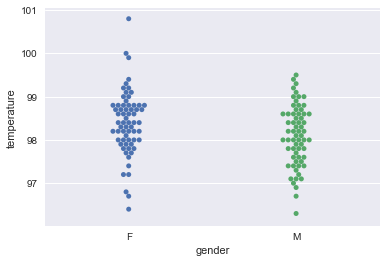

In [25]:
sns.swarmplot(x='gender', y='temperature', data = df)
plt.show()

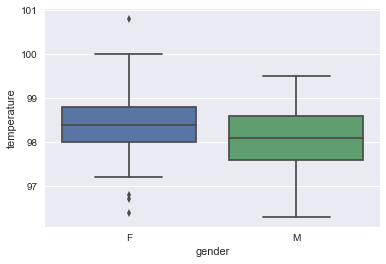

In [26]:
sns.boxplot(x='gender', y='temperature', data = df)
plt.show()

From the swarm and box plots that the average female temperature looks higher than the male temperature. Hence they might not have the same temperature distribution.

In [27]:
gender_mean_temp = df.groupby('gender')['temperature'].mean()
group_mean_temp = df.temperature.mean()
print('Average male body temperature is:', gender_mean_temp[1], '\nAverage female body temperature is:', gender_mean_temp[0],\
      '\nThe group body temperature mean is:',group_mean_temp)
      

Average male body temperature is: 98.1046153846154 
Average female body temperature is: 98.39384615384613 
The group body temperature mean is: 98.24923076923078


H0 : There is no difference in the gender mean body temperatures
 
 Ha : There is a difference in the gender body temperatures

In [72]:
male_temp = df.temperature[df.gender=='M'].values
female_temp = df.temperature[df.gender=='F'].values

def diff_of_means(data1, data2):
    """To determine the difference of the means of two data sets (series)"""
    mean_diff = np.mean(data1) - np.mean(data2)
    return mean_diff 

def permutation_sample(data1, data2):
    """To permute or scramble two sets of data and divide the scrambled data into 2 equal data samples"""
    data = np.concatenate((data1,data2))
    permuted_data = np.random.permutation(data)
    perm_smpl1 = permuted_data[:len(data1)]
    perm_smpl2 = permuted_data[len(data1):]
    
    return perm_smpl1, perm_smpl2

def draw_perm_replicate(data1, data2, func, size=1):
    """ Uses the permutation_sample function to create defined "size" number of replicates based on the function "func". """
    perm_replicates = np.empty(size)
    
    for i in range(size):
        perm_samp1, perm_samp2 = permutation_sample(data1,data2)
        perm_replicates[i] = func(perm_samp1, perm_samp2)
        
        return perm_replicates

# setting alpha

alpha = 0.05
    
# mean body temperatures

mean_bt = np.mean(df.temperature)

# Observed difference of means

Obs_diff_means = diff_of_means(female_temp, male_temp)

# Generating shifted arrays to the combined mean body temperature assuming H0 is true

male_temp_shifted = male_temp - np.mean(male_temp) + mean_bt
female_temp_shifted = female_temp - np.mean(female_temp)+ mean_bt


# Draw 10,000 bootstrap replicates for shifted arrays:

bs_reps1 = draw_bs_rep(female_temp_shifted,np.mean, size=10000)
bs_reps2 = draw_bs_rep(male_temp_shifted,np.mean, size=10000)

# Replicates of difference of means

bs_reps = bs_reps1-bs_reps2

# Compute p-value

pval_mndf = np.sum(bs_reps >= Obs_diff_means)/len(bs_reps)

if pval_mndf < alpha :
    print(f'The p-value is : {pval_mndf} < {alpha}. We reject the null hypothesis "H0 : There is no difference in the gender mean body temperatures" and suggest the alternate "Ha : There is a difference in the gender body temperatures"')
    print( f'\nThe difference in means is: {Obs_diff_means}')
else:
    print(f'The p-value is: {pval_mndf} > {alpha}.We fail to reject the null hypothesis H0. There is a likelihood that the mean gender body temperatures are equal')

The p-value is : 0.0096 < 0.05. We reject the null hypothesis "H0 : There is no difference in the gender mean body temperatures" and suggest the alternate "Ha : There is a difference in the gender body temperatures"

The difference in means is: 0.2892307692307696


**Normal Body Temperatures**

In [82]:
# draw bootstrap replicates

male_bs_replicates = draw_bs_rep(male_temp,np.mean,10000)
female_bs_replicates = draw_bs_rep(female_temp,np.mean,10000)

m1,m2 = np.percentile(male_bs_replicates,[.25,.95])
w1,w2 = np.percentile(female_bs_replicates,[.25,.95])

print(f'We have 95% confidence that the male normal body temperatures lies are between {m1:.4f}ºF and {m2:.4f}ºF')
print(f'\nWe have 95% confidence that the female normal body temperatures lies are between {w1:.4f}ºF and {w2:.4f}ºF')
print(f'\nThis represents a difference in body temperature between female and male is {np.sqrt((w1-m1)**2):.4f}ºF')

We have 95% confidence that the male normal body temperatures lies are between 97.8662ºF and 97.9077ºF

We have 95% confidence that the female normal body temperatures lies are between 98.1415ºF and 98.1785ºF

This represents a difference in body temperature between female and male is 0.2754ºF
